### Importing Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold

import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor




In [2]:
np.random.seed(42)

### Importing Data

In [3]:
df = pd.read_csv("https://open-data.s3.filebase.com/insurance.csv")

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Exploratory Data Analysis and Preprocessing of Data

In [5]:
df.shape

(1338, 7)

In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [9]:
#Finding out Missing Values
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='charges', ylabel='Density'>

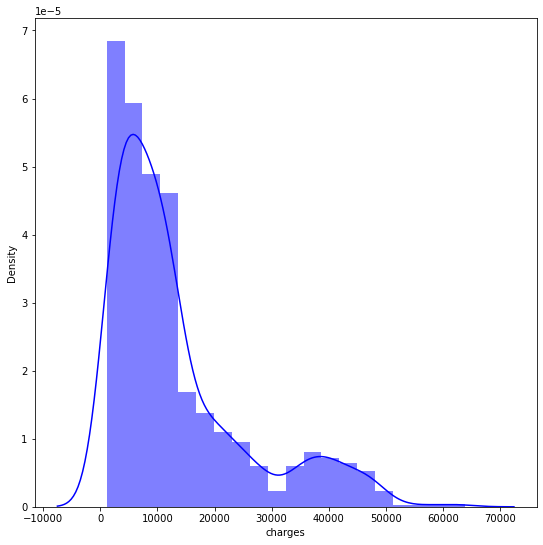

In [10]:
#Seeing how charges are distributed
print(df['charges'].describe())
plt.figure(figsize=(9,9))
sns.distplot(df['charges'], color='b', bins=20, hist_kws={'alpha':0.5})


### The charges are skewed to the right, with a few outliers. This looks approximately like an exponential distribution

In [11]:
df['charges'].skew() , df['charges'].kurtosis()

(1.5158796580240388, 1.6062986532967907)

In [12]:
df['log_charges'] = df['charges'].apply(lambda x : np.log(x))

In [13]:
df.head()

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176
1,18,male,33.770,1,no,southeast,1725.55230,7.453302
2,28,male,33.000,3,no,southeast,4449.46200,8.400538
3,33,male,22.705,0,no,northwest,21984.47061,9.998092
4,32,male,28.880,0,no,northwest,3866.85520,8.260197


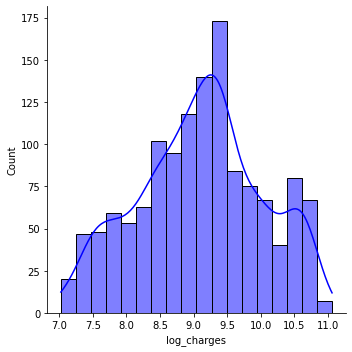

In [14]:
sns.displot(df['log_charges'],kde=True,color='blue')

In [15]:
df.describe()

,age,bmi,children,charges,log_charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,9.098659
std,14.049960,6.098187,1.205493,12110.011237,0.919527
min,18.000000,15.960000,0.000000,1121.873900,7.022756
25%,27.000000,26.296250,0.000000,4740.287150,8.463853
50%,39.000000,30.400000,1.000000,9382.033000,9.146552
75%,51.000000,34.693750,2.000000,16639.912515,9.719558
max,64.000000,53.130000,5.000000,63770.428010,11.063045


<AxesSubplot:xlabel='smoker', ylabel='charges'>

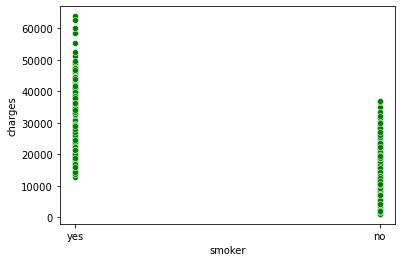

In [16]:
sns.scatterplot(y = df['charges'],x= df['smoker'], color='g')

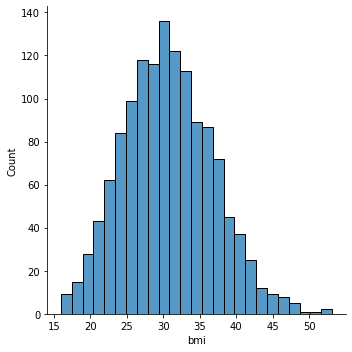

In [17]:
sns.displot(df['bmi'], kind = 'hist')

In [18]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [19]:
df.groupby('region')['charges'].agg([np.mean,np.median,np.max,np.min])

,mean,median,amax,amin
region,,,,
northeast,13406.384516,10057.652025,58571.07448,1694.7964
northwest,12417.575374,8965.795750,60021.39897,1621.3402
southeast,14735.411438,9294.131950,63770.42801,1121.8739
southwest,12346.937377,8798.593000,52590.82939,1241.5650


(-0.5, 3.5, -2010.5538055000002, 66902.8557155)

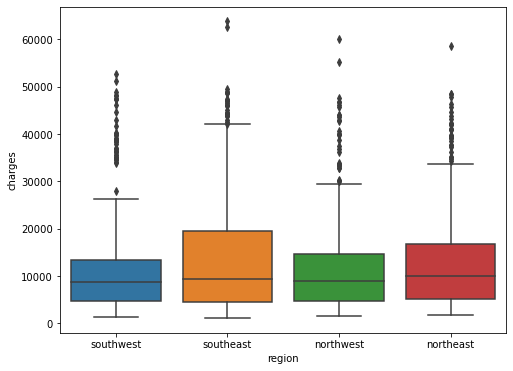

In [20]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="region", y="charges", data=df)
fig.axis()

In [21]:
df.groupby('sex')['charges'].agg([np.mean,np.median,np.max,np.min])

,mean,median,amax,amin
sex,,,,
female,12569.578844,9412.96250,63770.42801,1607.5101
male,13956.751178,9369.61575,62592.87309,1121.8739


(-0.5, 1.5, -2010.5538055000002, 66902.8557155)

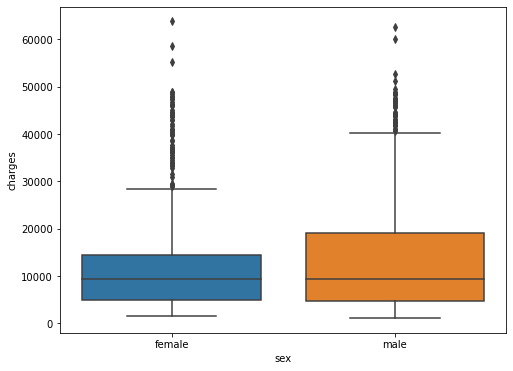

In [22]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="sex", y="charges", data=df)
fig.axis()

In [23]:
df.groupby('smoker')['charges'].agg([np.mean,np.median,np.max,np.min])

,mean,median,amax,amin
smoker,,,,
no,8434.268298,7345.40530,36910.60803,1121.8739
yes,32050.231832,34456.34845,63770.42801,12829.4551


(-0.5, 1.5, -2010.5538055000002, 66902.8557155)

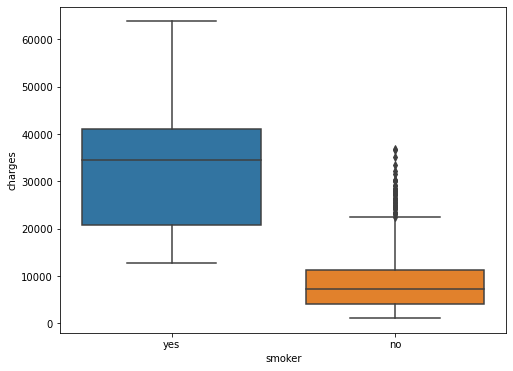

In [24]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="smoker", y="charges", data=df)
fig.axis()

### It is clear that being a person who is a smoker, has relatively higher charges than a non smoker.

In [25]:
df.groupby('children')['charges'].agg([np.mean,np.median,np.max,np.min])

,mean,median,amax,amin
children,,,,
0,12365.975602,9856.95190,63770.42801,1121.8739
1,12731.171832,8483.87015,58571.07448,1711.0268
2,15073.563734,9264.97915,49577.66240,2304.0022
3,15355.318367,10600.54830,60021.39897,3443.0640
4,13850.656311,11033.66170,40182.24600,4504.6624
5,8786.035247,8589.56505,19023.26000,4687.7970


(-0.5, 5.5, -2010.5538055000002, 66902.8557155)

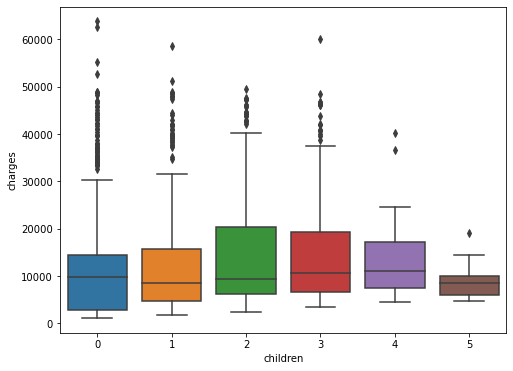

In [26]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="children", y="charges", data=df)
fig.axis()

In [27]:
df

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176
1,18,male,33.770,1,no,southeast,1725.55230,7.453302
2,28,male,33.000,3,no,southeast,4449.46200,8.400538
3,33,male,22.705,0,no,northwest,21984.47061,9.998092
4,32,male,28.880,0,no,northwest,3866.85520,8.260197
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,9.268661
1334,18,female,31.920,0,no,northeast,2205.98080,7.698927
1335,18,female,36.850,0,no,southeast,1629.83350,7.396233
1336,21,female,25.800,0,no,southwest,2007.94500,7.604867


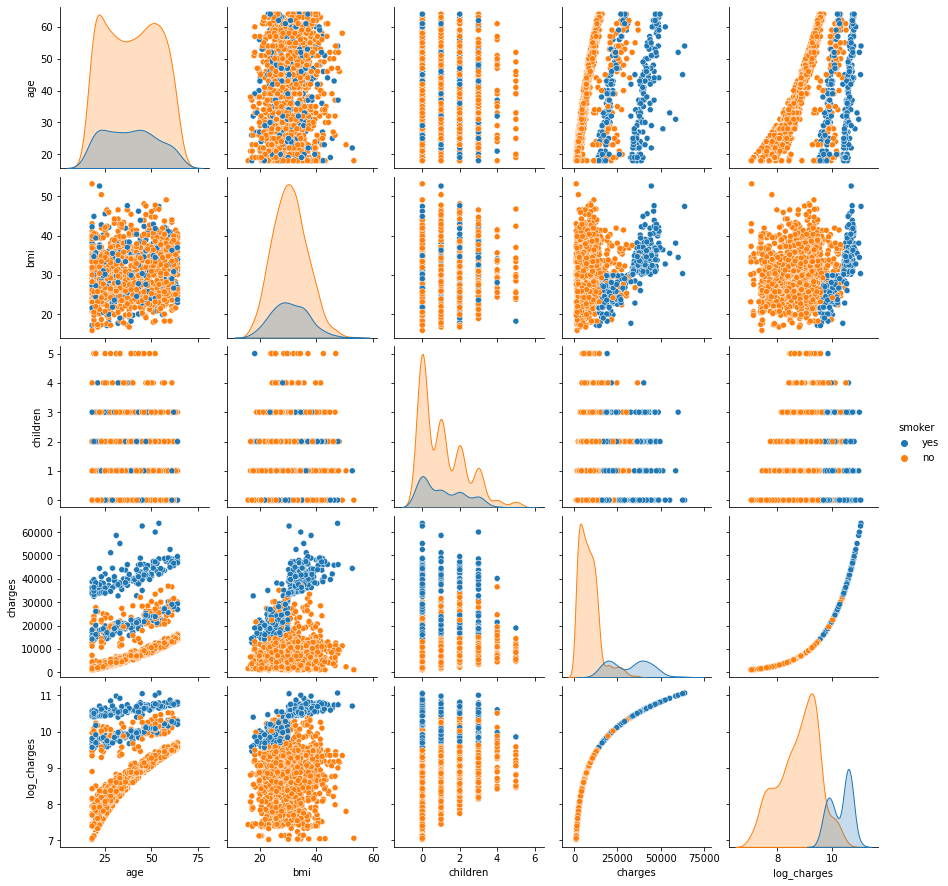

In [28]:
sns.pairplot(df,hue='smoker')

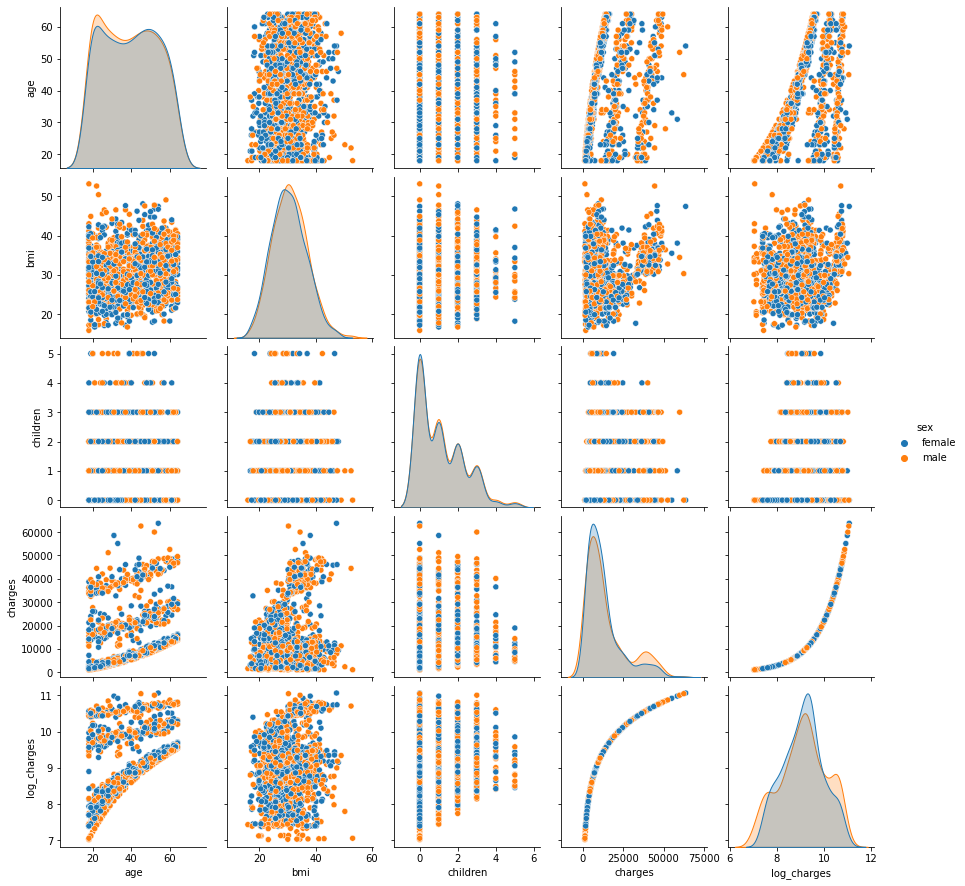

In [29]:
sns.pairplot(df,hue='sex')

### Converting categorical variables into numeric categories

In [30]:
df['sex_binary'] = df['sex'].apply(lambda x : 1 if(x=='female') else 0)
df['smoker_binary'] = df['smoker'].apply(lambda x : 1 if(x=='yes') else 0)

<AxesSubplot:>

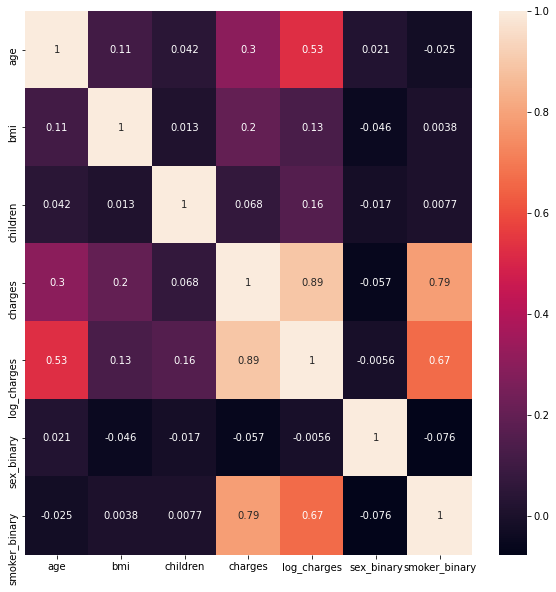

In [31]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr_matrix, annot=True)


### Creating dummy variables for categorical variable 'region'

In [32]:
x = pd.get_dummies(df['region'])
df = df.join(x)

In [33]:
df.head()

,age,sex,bmi,children,smoker,region,charges,log_charges,sex_binary,smoker_binary,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176,1,1,0,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,7.453302,0,0,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,8.400538,0,0,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,9.998092,0,0,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,8.260197,0,0,0,1,0,0


In [34]:
df['age'].min(),df['age'].max(),df['age'].mean()

(18, 64, 39.20702541106129)

In [35]:
df

,age,sex,bmi,children,smoker,region,charges,log_charges,sex_binary,smoker_binary,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176,1,1,0,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,7.453302,0,0,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,8.400538,0,0,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,9.998092,0,0,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,8.260197,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,9.268661,0,0,0,1,0,0
1334,18,female,31.920,0,no,northeast,2205.98080,7.698927,1,0,1,0,0,0
1335,18,female,36.850,0,no,southeast,1629.83350,7.396233,1,0,0,0,1,0
1336,21,female,25.800,0,no,southwest,2007.94500,7.604867,1,0,0,0,0,1


In [36]:
X = df[['age','bmi','children','sex_binary','smoker_binary','northeast','northwest','southeast','southwest']]
y=df['log_charges']

By Performing EDA and Preprocessing, we can make the following observations:
1. Charges follow an approximate exponential i.e a non normal distribution, hence we can use the logarithm of charges to obtain a better fit.
2. As seen in the correlation matrix, both smoker and age have a high positive correlation with both charges and log of charges
3. In the Pairwise relationsship obtained using sns.pairplot, we can see that people with a high bmi tend to be a smoker and hence have higher charges
6. There are some outliers in our data set, so we have used log transformation on charges and MinMaXScaler on the x values (This has been done in the next section)

### Splitting the Data into Train and Test

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [38]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((1070, 9), (268, 9), (1070,), (268,))

In [39]:
X_test

,age,bmi,children,sex_binary,smoker_binary,northeast,northwest,southeast,southwest
764,45,25.175,2,1,0,1,0,0,0
887,36,30.020,0,1,0,0,1,0,0
890,64,26.885,0,1,1,0,1,0,0
1293,46,25.745,3,0,0,0,1,0,0
259,19,31.920,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
109,63,35.090,0,0,1,0,0,1,0
575,58,27.170,0,1,0,0,1,0,0
535,38,28.025,1,0,0,1,0,0,0
543,54,47.410,0,1,1,0,0,1,0


In [40]:
X_train

,age,bmi,children,sex_binary,smoker_binary,northeast,northwest,southeast,southwest
560,46,19.950,2,1,0,0,1,0,0
1285,47,24.320,0,1,0,1,0,0,0
1142,52,24.860,0,1,0,0,0,1,0
969,39,34.320,5,1,0,0,0,1,0
486,54,21.470,3,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1095,18,31.350,4,1,0,1,0,0,0
1130,39,23.870,5,1,0,0,0,1,0
1294,58,25.175,0,0,0,1,0,0,0
860,37,47.600,2,1,1,0,0,0,1


In [41]:
mm = MinMaxScaler()
X_train_scaled = pd.DataFrame(mm.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(mm.fit_transform(X_test), columns=X_test.columns)

In [42]:
X_train

,age,bmi,children,sex_binary,smoker_binary,northeast,northwest,southeast,southwest
560,46,19.950,2,1,0,0,1,0,0
1285,47,24.320,0,1,0,1,0,0,0
1142,52,24.860,0,1,0,0,0,1,0
969,39,34.320,5,1,0,0,0,1,0
486,54,21.470,3,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1095,18,31.350,4,1,0,1,0,0,0
1130,39,23.870,5,1,0,0,0,1,0
1294,58,25.175,0,0,0,1,0,0,0
860,37,47.600,2,1,1,0,0,0,1


In [43]:
X_train_scaled

,age,bmi,children,sex_binary,smoker_binary,northeast,northwest,southeast,southwest
0,0.608696,0.107345,0.4,1.0,0.0,0.0,1.0,0.0,0.0
1,0.630435,0.224913,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.739130,0.239440,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.456522,0.493947,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.782609,0.148238,0.6,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1065,0.000000,0.414044,0.8,1.0,0.0,1.0,0.0,0.0,0.0
1066,0.456522,0.212806,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1067,0.869565,0.247915,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1068,0.413043,0.851224,0.4,1.0,1.0,0.0,0.0,0.0,1.0


In [44]:
X_train

,age,bmi,children,sex_binary,smoker_binary,northeast,northwest,southeast,southwest
560,46,19.950,2,1,0,0,1,0,0
1285,47,24.320,0,1,0,1,0,0,0
1142,52,24.860,0,1,0,0,0,1,0
969,39,34.320,5,1,0,0,0,1,0
486,54,21.470,3,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1095,18,31.350,4,1,0,1,0,0,0
1130,39,23.870,5,1,0,0,0,1,0
1294,58,25.175,0,0,0,1,0,0,0
860,37,47.600,2,1,1,0,0,0,1


### Feature Selection

In [45]:
# pearson's correlation feature selection for numeric input and numeric output
feats = SelectKBest(k=5, score_func=f_regression)
select = feats.fit_transform(X_train_scaled,y_train)
features_list=X_train_scaled.columns
print(features_list[feats.get_support()])

Index(['age', 'bmi', 'children', 'smoker_binary', 'southwest'], dtype='object')


In [46]:
X_train_scaled.shape , select.shape

((1070, 9), (1070, 5))

### Creating a function to plot regression metrics

In [47]:
def regression_metrics(y_true, y_pred):

    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,3))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,3))
    print('r2: ', round(r2,3))
    print('MAE: ', round(mean_absolute_error,3))
    print('MSE: ', round(mse,3))
    print('MedianAR: ', round(median_absolute_error,3))
    print('RMSE: ', round(np.sqrt(mse),3))
    
    return(round(explained_variance,3),round(mean_squared_log_error,3),
           round(r2,3),round(mean_absolute_error,3),round(mse,3),
           round(median_absolute_error,3),round(np.sqrt(mse),3))

## Metrics Used :
#### Explained Variance - The explained variance score explains the dispersion of errors of a given dataset
#### Mean Absolute Error - In statistics, mean absolute error is a measure of errors between paired observations expressing the same phenomenon. It measures the average magnitude or errors in a dataset.
#### Mean Squared Log Error - The mean_squared_log_error function computes a risk metric corresponding to the expected value of the squared logarithmic (quadratic) error or loss.
#### Root Mean Squared Error - MSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.
#### R Squared - R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. 
#### Mean Squared Error - The mean squared error (MSE) tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. 


In [48]:
scores_df={}

### OLS Linear Regression

In [49]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
coeff_df_lin_reg = pd.DataFrame(lin_reg.coef_, X_train_scaled.columns, columns=['Coefficient'])
coeff_df_lin_reg

,Coefficient
age,1.577139e+00
bmi,4.887479e-01
children,4.724730e-01
sex_binary,6.156859e-02
smoker_binary,1.559041e+00
northeast,4.424938e+13
northwest,4.424938e+13
southeast,4.424938e+13
southwest,4.424938e+13


In [50]:
y_pred = lin_reg.predict(X_test_scaled)
lin_reg_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
lin_reg_results

,Actual,Predicted
764,9.115488,9.109375
887,8.570198,8.593750
890,10.286400,11.070312
1293,9.137973,9.101562
259,10.426744,9.531250
...,...,...
109,10.759084,11.046875
575,9.411066,9.312500
535,8.710640,8.750000
543,11.063045,10.968750


In [51]:
scores_df['OLS_Linear_Regression'] = regression_metrics(y_test,y_pred)

explained_variance:  0.806
mean_squared_log_error:  0.002
r2:  0.804
MAE:  0.268
MSE:  0.176
MedianAR:  0.139
RMSE:  0.419


Text(0, 0.5, 'Predicted Y Values')

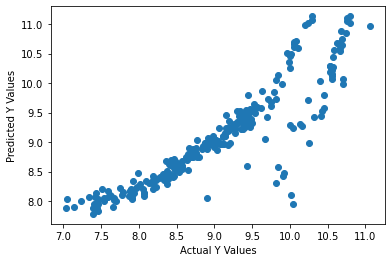

In [52]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Y Values')
plt.ylabel('Predicted Y Values')

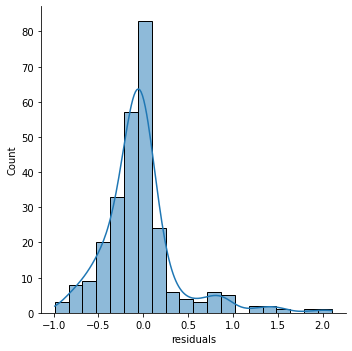

In [53]:
residual = y_test-y_pred
sns.displot((residual),bins=20,kde=True).set_axis_labels('residuals') ## To estimate the probability density function, set kde=True


### KNN Regression

In [54]:
knn_grid=GridSearchCV(estimator=KNeighborsRegressor(),param_grid={'n_neighbors':np.arange(1,20)},cv=5)
knn_grid.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [55]:
knn_grid.best_params_["n_neighbors"]

13

In [56]:
knn=KNeighborsRegressor(n_neighbors=knn_grid.best_params_["n_neighbors"])
knn.fit(X_train_scaled,y_train)
y_pred=knn.predict(X_test_scaled)
knn_reg_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
knn_reg_results

,Actual,Predicted
764,9.115488,9.114365
887,8.570198,8.607351
890,10.286400,10.251581
1293,9.137973,9.150058
259,10.426744,10.004606
...,...,...
109,10.759084,10.648871
575,9.411066,9.501301
535,8.710640,8.800147
543,11.063045,10.501626


In [57]:
scores_df['KNN_Regression'] = regression_metrics(y_test,y_pred)

explained_variance:  0.818
mean_squared_log_error:  0.002
r2:  0.818
MAE:  0.259
MSE:  0.164
MedianAR:  0.174
RMSE:  0.405


Text(0, 0.5, 'Predicted Y Values')

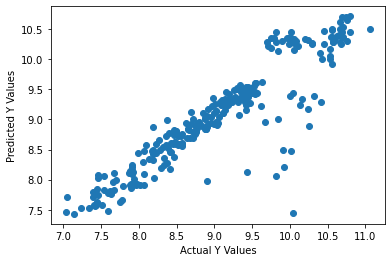

In [58]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Y Values')
plt.ylabel('Predicted Y Values')

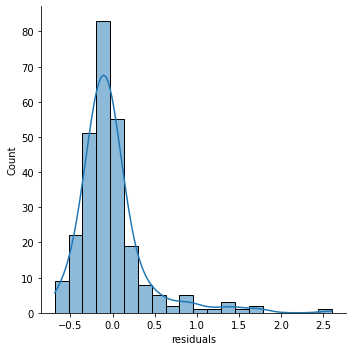

In [59]:
sns.displot((y_test-y_pred),bins=20,kde=True).set_axis_labels('residuals')

### Lasso Regression

In [60]:
cv = RepeatedKFold(n_splits=5,random_state=42)
las_alpha = np.linspace(0.01,0.5,num=20)
grid =dict()
grid['alpha'] = las_alpha
gscv = GridSearchCV(Lasso(),grid,scoring='r2',cv=cv,n_jobs=1)
las_res = gscv.fit(X_train_scaled,y_train)
print(las_res.best_params_)
# for i in las_alpha:
#     

{'alpha': 0.01}


In [61]:
best_par = las_res.best_params_['alpha']
las = Lasso(alpha = best_par)
las.fit(X_train_scaled,y_train)
y_pred=las.predict(X_test_scaled)
las_reg_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
las_reg_results

,Actual,Predicted
764,9.115488,9.068080
887,8.570198,8.637245
890,10.286400,11.024927
1293,9.137973,9.109092
259,10.426744,9.543913
...,...,...
109,10.759084,10.983343
575,9.411066,9.347919
535,8.710640,8.759965
543,11.063045,10.741093


In [62]:
coeff_df_lass_reg = pd.DataFrame(las.coef_, X_train_scaled.columns, columns=['Coefficient'])
coeff_df_lass_reg

,Coefficient
age,1.498103
bmi,0.072908
children,0.301050
sex_binary,0.025742
smoker_binary,1.482184
northeast,0.027184
northwest,0.000000
southeast,-0.000000
southwest,-0.000000


In [63]:
scores_df['Lasso_Regression'] = regression_metrics(y_test,y_pred)

explained_variance:  0.789
mean_squared_log_error:  0.002
r2:  0.787
MAE:  0.276
MSE:  0.191
MedianAR:  0.123
RMSE:  0.437


Text(0, 0.5, 'Predicted Y Values')

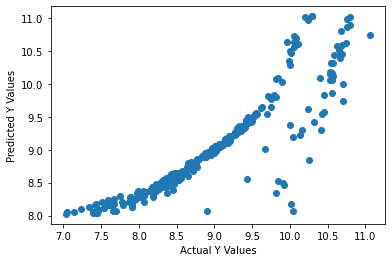

In [64]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Y Values')
plt.ylabel('Predicted Y Values')

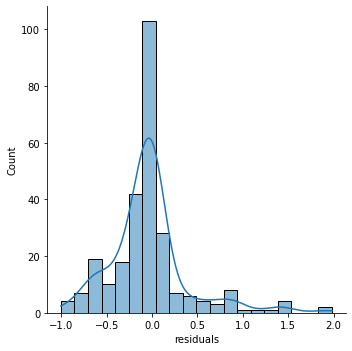

In [65]:
sns.displot((y_test-y_pred),bins=20,kde=True).set_axis_labels('residuals')

### Ridge Regression

In [66]:
cv = RepeatedKFold(n_splits=5,random_state=42)
ridge_alpha = np.linspace(0.01,0.5,num=20)
grid =dict()
grid['alpha'] = ridge_alpha
gscv = GridSearchCV(Ridge(),grid,scoring='r2',cv=cv,n_jobs=1)
rid_res = gscv.fit(X_train_scaled,y_train)
print(rid_res.best_params_)
# for i in las_alpha:
#     

{'alpha': 0.44842105263157894}


In [67]:
best_par = rid_res.best_params_['alpha']
rid = Ridge(alpha = best_par)
rid.fit(X_train_scaled,y_train)
y_pred=rid.predict(X_test_scaled)
rid_reg_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
rid_reg_results

,Actual,Predicted
764,9.115488,9.107482
887,8.570198,8.628034
890,10.286400,11.086531
1293,9.137973,9.111278
259,10.426744,9.548280
...,...,...
109,10.759084,11.014085
575,9.411066,9.338505
535,8.710640,8.742632
543,11.063045,10.952790


In [68]:
coeff_df_ridge_reg = pd.DataFrame(rid.coef_, X_train_scaled.columns, columns=['Coefficient'])
coeff_df_ridge_reg

,Coefficient
age,1.568557
bmi,0.498306
children,0.459600
sex_binary,0.073945
smoker_binary,1.547402
northeast,0.078290
northwest,0.022070
southeast,-0.056651
southwest,-0.043710


In [69]:
scores_df['Ridge_Regression'] = regression_metrics(y_test,y_pred)

explained_variance:  0.806
mean_squared_log_error:  0.002
r2:  0.805
MAE:  0.27
MSE:  0.176
MedianAR:  0.147
RMSE:  0.419


Text(0, 0.5, 'Predicted Y Values')

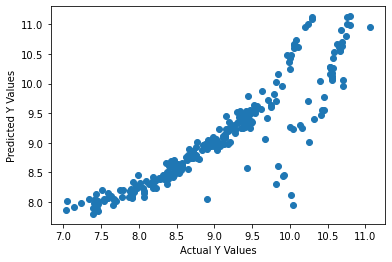

In [70]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Y Values')
plt.ylabel('Predicted Y Values')

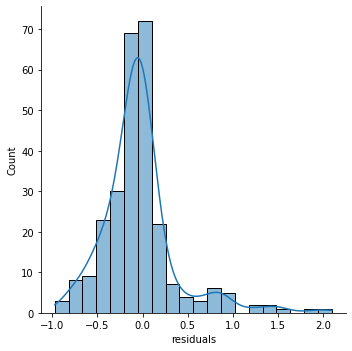

In [71]:
sns.displot((y_test-y_pred),bins=20,kde=True).set_axis_labels('residuals')

### Random Forest Regression

In [72]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': [2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300,500]
}
rf = RandomForestRegressor()
rf_tuned = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2 , verbose=2)
rf_tuned.fit(X_train_scaled,y_train)
rf_tuned.best_params_

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_split=8, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_split=8, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_split=8, n_estimators=300; total time=   0.2s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_split=8, n_estimators=500; total time=   0.4s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_split=8, n_estimators=500; total time=   0.4s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_dep

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_split': 8,
 'n_estimators': 500}

In [73]:
rf_tuned.best_estimator_

RandomForestRegressor(max_depth=110, max_features=3, min_samples_split=8,
                      n_estimators=500)

In [74]:
ran_reg=rf_tuned.best_estimator_
ran_reg.fit(X_train_scaled,y_train)
y_pred=ran_reg.predict(X_test_scaled)
ran_reg_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
ran_reg_results

,Actual,Predicted
764,9.115488,9.212468
887,8.570198,8.575966
890,10.286400,10.180370
1293,9.137973,9.200973
259,10.426744,10.315176
...,...,...
109,10.759084,10.676797
575,9.411066,9.408599
535,8.710640,8.822383
543,11.063045,10.629173


In [75]:
ran_reg.feature_importances_

array([0.36353618, 0.08906078, 0.04339343, 0.01030417, 0.47084528,
       0.00704152, 0.00467101, 0.00581073, 0.0053369 ])

<BarContainer object of 9 artists>

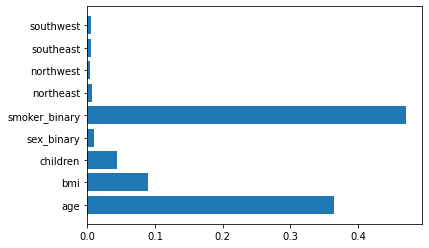

In [76]:
plt.barh(X_train_scaled.columns, ran_reg.feature_importances_)

In [77]:
scores_df['Random_Forest_Regressor'] = regression_metrics(y_test,y_pred)

explained_variance:  0.849
mean_squared_log_error:  0.001
r2:  0.849
MAE:  0.215
MSE:  0.136
MedianAR:  0.125
RMSE:  0.369


Text(0, 0.5, 'Predicted Y Values')

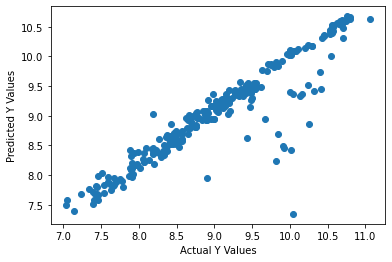

In [78]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Y Values')
plt.ylabel('Predicted Y Values')

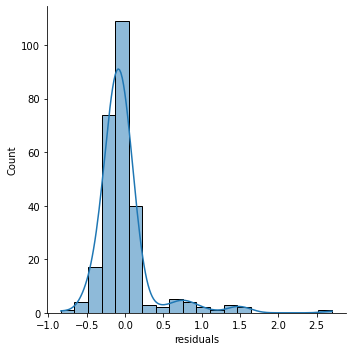

In [79]:
sns.displot((y_test-y_pred),bins=20,kde=True).set_axis_labels('residuals')

### Decision Tree Regressor

In [80]:
param_grid={"splitter":["best","random"],
            "max_depth" : [1,5,9],
           "min_samples_leaf":[1,4,10],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,60,90] }
dt = DecisionTreeRegressor()
dt_tuned = GridSearchCV(estimator = dt, param_grid = param_grid, 
                          cv = 2 , verbose=2)
dt_tuned.fit(X_train_scaled,y_train)
dt_tuned.best_params_

Fitting 2 folds for each of 288 candidates, totalling 576 fits
[CV] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, splitter=best; total time=   0.0s
[CV] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, splitter=best; total time=   0.0s
[CV] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, splitter=random; total time=   0.0s
[CV] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=1, splitter=random; total time=   0.0s
[CV] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, splitter=best; total time=   0.0s
[CV] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, splitter=best; total time=   0.0s
[CV] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, splitter=random; total time=   0.0s
[CV] END max_depth=1, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, splitter=random; total time=   0.1s
[

{'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': 90,
 'min_samples_leaf': 10,
 'splitter': 'best'}

In [81]:
dt_tuned.best_estimator_

DecisionTreeRegressor(max_depth=9, max_leaf_nodes=90, min_samples_leaf=10)

In [82]:
dt_reg=dt_tuned.best_estimator_
dt_reg.fit(X_train_scaled,y_train)
y_pred=dt_reg.predict(X_test_scaled)
dt_reg_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dt_reg_results

,Actual,Predicted
764,9.115488,9.118521
887,8.570198,8.581765
890,10.286400,10.212561
1293,9.137973,9.118521
259,10.426744,10.440576
...,...,...
109,10.759084,10.777144
575,9.411066,9.465342
535,8.710640,8.925208
543,11.063045,10.777144


In [83]:
dt_reg.feature_importances_

array([4.10718606e-01, 4.40925102e-02, 2.79985891e-02, 7.58502323e-03,
       4.99659641e-01, 7.83507330e-03, 1.29639498e-03, 3.44455276e-04,
       4.69707625e-04])

<BarContainer object of 9 artists>

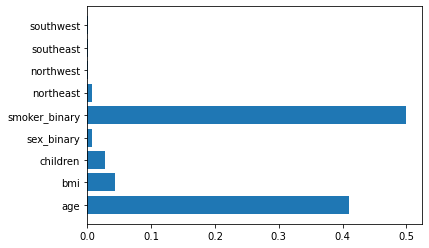

In [84]:
plt.barh(X_train_scaled.columns, dt_reg.feature_importances_)

In [85]:
scores_df['Decison_Tree_Regressor'] = regression_metrics(y_test,y_pred)

explained_variance:  0.838
mean_squared_log_error:  0.002
r2:  0.838
MAE:  0.211
MSE:  0.146
MedianAR:  0.106
RMSE:  0.382


Text(0, 0.5, 'Predicted Y Values')

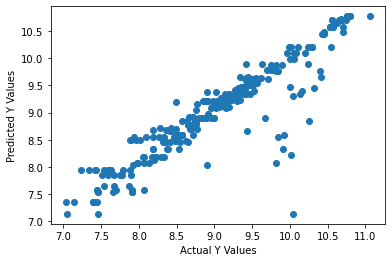

In [86]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Y Values')
plt.ylabel('Predicted Y Values')

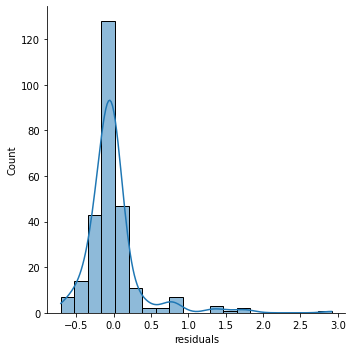

In [87]:
sns.displot((y_test-y_pred),bins=20,kde=True).set_axis_labels('residuals')

### Overall Comparision between models

In [88]:
scores_df

{'OLS_Linear_Regression': (0.806, 0.002, 0.804, 0.268, 0.176, 0.139, 0.419),
 'KNN_Regression': (0.818, 0.002, 0.818, 0.259, 0.164, 0.174, 0.405),
 'Lasso_Regression': (0.789, 0.002, 0.787, 0.276, 0.191, 0.123, 0.437),
 'Ridge_Regression': (0.806, 0.002, 0.805, 0.27, 0.176, 0.147, 0.419),
 'Random_Forest_Regressor': (0.849, 0.001, 0.849, 0.215, 0.136, 0.125, 0.369),
 'Decison_Tree_Regressor': (0.838, 0.002, 0.838, 0.211, 0.146, 0.106, 0.382)}

In [89]:
scores = pd.DataFrame.from_dict(scores_df, orient='index',columns=['explained_variance','mean_squared_log_error',
                                                                  'R2','MAE','MSE','MedianAE','RMSE'])

In [90]:
scores

,explained_variance,mean_squared_log_error,R2,MAE,MSE,MedianAE,RMSE
OLS_Linear_Regression,0.806,0.002,0.804,0.268,0.176,0.139,0.419
KNN_Regression,0.818,0.002,0.818,0.259,0.164,0.174,0.405
Lasso_Regression,0.789,0.002,0.787,0.276,0.191,0.123,0.437
Ridge_Regression,0.806,0.002,0.805,0.270,0.176,0.147,0.419
Random_Forest_Regressor,0.849,0.001,0.849,0.215,0.136,0.125,0.369
Decison_Tree_Regressor,0.838,0.002,0.838,0.211,0.146,0.106,0.382


### We can clearly see that Linear models have performed comparatively weaker than the Random Forest Regressor and Decision Tree Regressor. Random Forest Regressor has the highest R aquared value, while the Decision tree Regressor has the second highest R Squared values along with lowest error estimates.